Дата сет содержит реферативные данные о патентах в различных областях. Необходимо выполнить кластеризацию научных патентов с применением hierarchical clustering и DBSCAN.

План анализа:
1. Предварительная обработка данных
2. Векторизация текстов
3. Кластеризация патентов
4. Оценка результатов
5. Анализ тематической принадлежности кластеров.
6. Сравнение результатов Hierarchical Clustering и DBSCAN.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv(r"Clustering\Data\08_patents.csv")

In [3]:
df.head(3)

,Application Date,Title,abstract,text
0,2019-04-01,THREE DIMENSIONAL CERAMIC MATRIX COMPOSITE WAL...,A component (68) fabricated from a three dimen...,THREE DIMENSIONAL CERAMIC MATRIX COMP...
1,2020-03-01,METHOD FOR FABRICATING A 3D COMPOSITE STRUCTUR...,A method for fabricating a composite part usin...,METHOD FOR FABRICATING A 3D COMPOSITE...
2,2020-04-01,SHARK RESISTANT COMPOSITE FABRIC,The present invention discloses a shark resist...,SHARK RESISTANT COMPOSITE FABRIC ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708 entries, 0 to 2707
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Application Date  2708 non-null   object
 1   Title             2708 non-null   object
 2   abstract          2708 non-null   object
 3   text              2708 non-null   object
dtypes: object(4)
memory usage: 84.8+ KB


In [5]:
df.describe()

,Application Date,Title,abstract,text
count,2708,2708,2708,2708
unique,73,1794,707,1949
top,2020-03-01,SYSTEM FOR ADDITIVELY MANUFACTURING COMPOSITE ...,\n,COMPOSITE MATERIAL Field of the ...
freq,257,72,1645,13


Датасет содержит 2708 записей о патентах, представленных четырьмя текстовыми столбцами:
1. Application Date – дата подачи заявки на патент.
2. Title – название патента.
3. abstract – аннотация.
4. text – основной текст патента.

Особенности:
- Даты представлены в текстовом формате.

- Количество уникальных значений в столбцах: Title – 1794 (многие названия повторяются). abstract – 707 (есть значительное дублирование). text – 1949 (различия в основном тексте шире, чем в аннотациях).

Наиболее частая дата подачи заявки – 2020-03-01 (257 записей).

Пропущенных значений нет, но есть пустые строки (например, "\n" в аннотациях).

# EDA - Предварительная обработка данных

In [6]:
import re

Приведем даты к формату datetime

In [7]:
df["Application Date"] = pd.to_datetime(df["Application Date"], errors="coerce")

Очистка текстовых данных (удаление лишних символов, приведение к нижнему регистру)

In [8]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r"\s+", " ", text)  # Удаление лишних пробелов и символов новой строки
    text = re.sub(r"[^a-z0-9\s]", "", text)  # Удаление знаков препинания
    return text.strip()

In [9]:
df["Title"] = df["Title"].apply(clean_text)
df["abstract"] = df["abstract"].apply(clean_text)
df["text"] = df["text"].apply(clean_text)

Проверка дубликатов (особенно в abstract и text)

In [10]:
# Удаление дубликатов только по Title и abstract
df.drop_duplicates(subset=["Title", "abstract", "text"], keep="first", inplace=True)

In [11]:
# Проверка на пустые строки в abstract
df = df[df["abstract"].str.strip() != ""]

In [12]:
# Выводим информацию после обработки
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 0 to 2707
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Application Date  718 non-null    datetime64[ns]
 1   Title             718 non-null    object        
 2   abstract          718 non-null    object        
 3   text              718 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 28.0+ KB


# Векторизация текста

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

Оценка частотности терминов TF-IDF

In [14]:
# Выбираем столбцы для векторизации
text_data = df["Title"] + " " + df["abstract"] + " " + df["text"]

In [15]:
# TF-IDF векторизация
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")  # Ограничим 5000 самых важных слов
X_tfidf = vectorizer.fit_transform(text_data)

In [16]:
# Вывод формы матрицы (количество документов, количество признаков)
print("Размерность TF-IDF матрицы:", X_tfidf.shape)

Размерность TF-IDF матрицы: (718, 5000)


Word2Vec (более глубокий анализ)

In [ ]:
import nltk
nltk.download("punkt")  # Загрузка токенизатора
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [18]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [19]:
# Токенизация текстов
df["tokenized_text"] = df["Title"] + " " + df["abstract"] + " " + df["text"]
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: word_tokenize(x.lower()))

In [20]:
# Обучаем Word2Vec
model = Word2Vec(sentences=df["tokenized_text"], vector_size=100, window=5, min_count=2, workers=4)

In [21]:
# Пример вектора слова
print("Вектор слова 'composite':", model.wv["composite"])

Вектор слова 'composite': [ 1.8924159   0.43662578 -1.879204    1.2133706   0.9170873   0.77276766
 -0.5260966   1.9578289   0.00702957  2.1805134   1.5493412  -0.18285084
 -0.03089617  0.99933034  0.5982944   1.2983019  -2.5538948   2.4541996
 -1.9417226   0.5040745   1.6442883   1.599962   -1.0819372  -0.08553082
 -2.2490776  -1.4511914   1.4540582  -2.5132709  -1.0252811  -0.679807
  0.04548145  1.0175562  -0.6614044   3.0197885   1.0746546   0.5088725
  3.2508886   0.4191698  -0.04457249 -1.7972785   1.9475563  -0.10746556
 -2.2443042   0.62372583 -0.37399936 -1.6629223   0.8867764   0.6121956
  1.4588926   3.7140422  -2.6532419   0.34837112 -1.8856114  -1.6088895
 -1.9576571  -0.44171914  1.418274   -2.694625   -0.07521685  0.12954746
  3.9863431   0.94777364 -1.4760848  -1.0524604   4.117058    0.668048
 -0.9811108  -2.8972845  -0.465259   -0.52791697  0.14158581  0.69822454
 -0.8981739   2.772104   -1.8043773  -0.7201657   1.6424403  -0.5385713
  1.0890917  -1.4935253   1.696464

BERT (более продвинутая модель)

# Уменьшение размерности с помощью PCA

In [23]:
from sklearn.decomposition import PCA

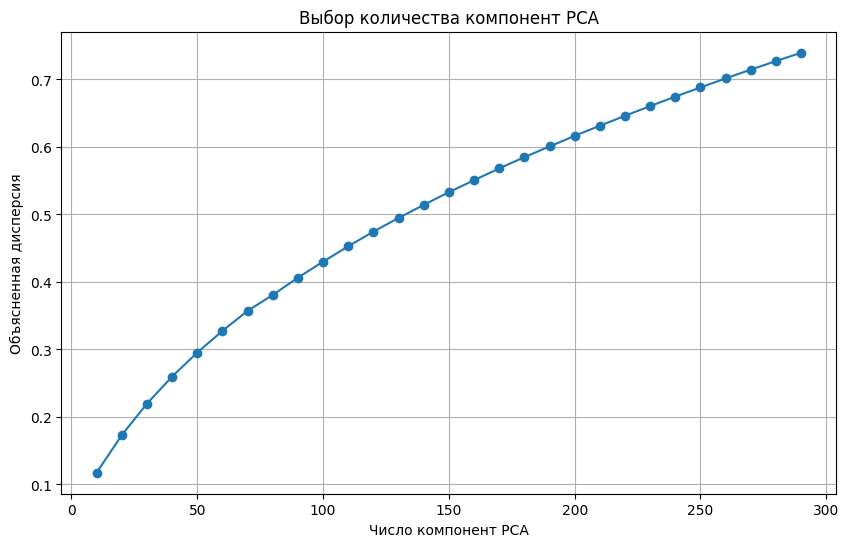

In [32]:
explained_variance = []
components = range(10, 300, 10)  # Пробуем от 10 до 300 компонент с шагом 10

for n in components:
    pca = PCA(n_components=n)
    pca.fit(X_tfidf.toarray())
    explained_variance.append(sum(pca.explained_variance_ratio_))

# График
plt.figure(figsize=(10, 6))
plt.plot(components, explained_variance, marker='o', linestyle='-')
plt.xlabel("Число компонент PCA")
plt.ylabel("Объясненная дисперсия")
plt.title("Выбор количества компонент PCA")
plt.grid(True)
plt.show()


In [38]:
# Применяем PCA с 300 компонентами
n_components = 300
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(X_tfidf.toarray())

In [39]:
# Проверим размерность
print("Размерность после PCA:", pca_features.shape)

Размерность после PCA: (718, 300)


In [40]:
# Проверим, сколько объясненной дисперсии
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Объясненная дисперсия с 300 компонентами: {explained_variance:.4f}")

Объясненная дисперсия с 300 компонентами: 0.7516


# Кластеризация с помощью Hierarchical Clustering

In [ ]:
import scipy.cluster.hierarchy as sch

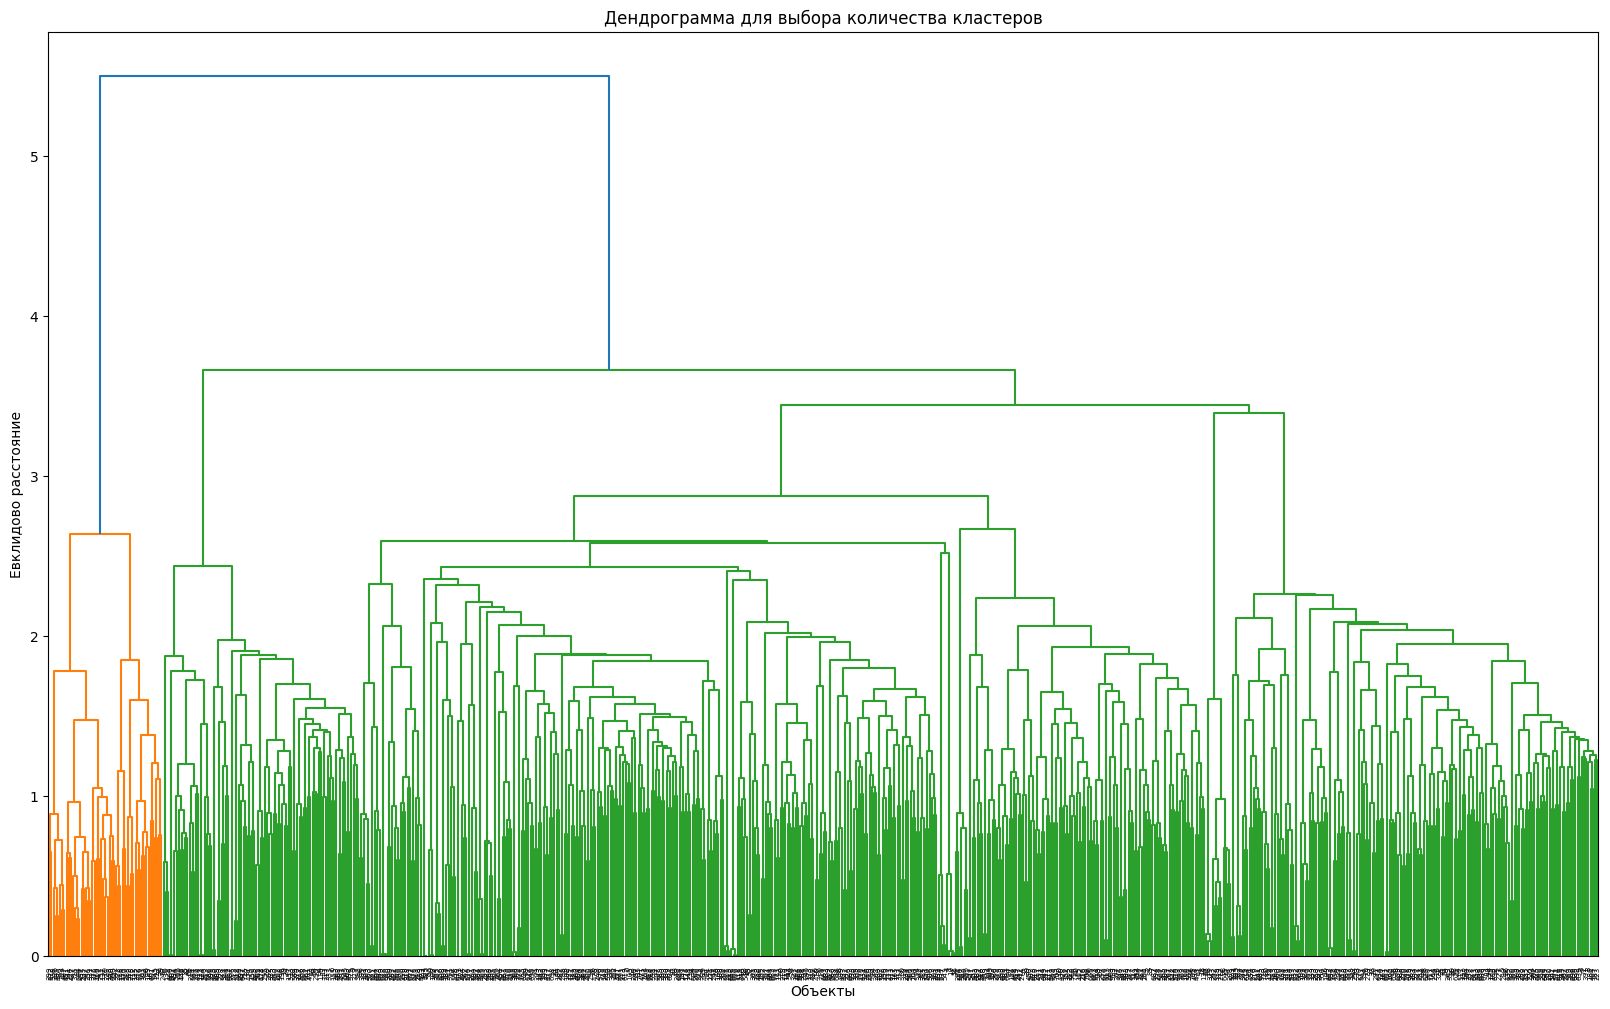

In [42]:
# Построение дендрограммы
plt.figure(figsize=(20, 12))
linkage_matrix = sch.linkage(pca_features, method='ward')
sch.dendrogram(linkage_matrix)
plt.title("Дендрограмма для выбора количества кластеров")
plt.xlabel("Объекты")
plt.ylabel("Евклидово расстояние")
plt.show()

Синий — объединяет всё дерево на самом высоком уровне.

Зелёный — огромная группа, которая делится на более мелкие подгруппы.

Оранжевый — более плотный, потенциально отдельный кластер.

Самый большой разрыв — примерно на высоте 3.5–4.0, где дерево делится на две большие ветви (зелёную и оранжевую).

Ещё один заметный уровень — около 2.0, где зелёная группа делится на несколько подгрупп.

Попробуем найти оптимальное количество кластеров с помощью метода "разреза по высоте"

In [60]:
from scipy.cluster.hierarchy import linkage, fcluster

In [61]:
cut_height = 3.5  

# Определяем кластеры
clusters = fcluster(linkage_matrix, cut_height, criterion="distance")

In [62]:
print("Количество кластеров:", np.unique(clusters).shape[0])

Количество кластеров: 3


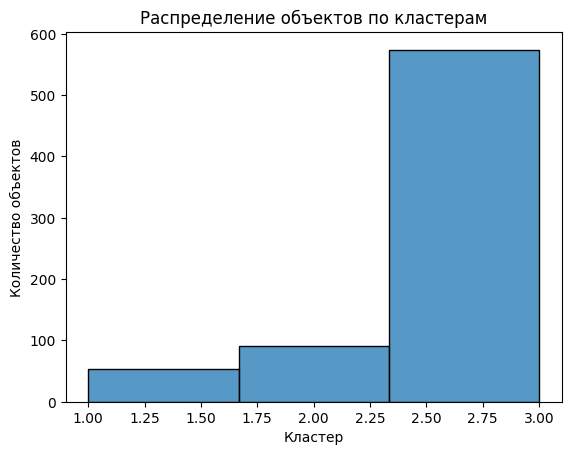

In [63]:
sns.histplot(clusters, bins=len(np.unique(clusters)), kde=False)
plt.xlabel("Кластер")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.show()

# Анализ кластеров

In [64]:
df_clusters = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca_features.shape[1])])
df_clusters["Cluster"] = clusters

In [65]:
# Количество объектов в кластерах
print(df_clusters["Cluster"].value_counts())

Cluster
3    574
2     91
1     53
Name: count, dtype: int64


In [66]:
# Средние значения признаков по кластерам
print(df_clusters.groupby("Cluster").mean())

              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Cluster                                                                         
1        0.494810 -0.088181  0.042330  0.068701 -0.011055  0.002668 -0.034897   
2       -0.097510 -0.165857 -0.120611  0.062643  0.043252  0.067165  0.003087   
3       -0.030229  0.034436  0.015213 -0.016275 -0.005836 -0.010894  0.002733   

              PC8       PC9      PC10  ...     PC291     PC292     PC293  \
Cluster                                ...                                 
1        0.000040  0.027241 -0.019886  ... -0.000213 -0.001582 -0.000535   
2        0.001439  0.007684 -0.002081  ...  0.000483 -0.000647  0.000746   
3       -0.000232 -0.003734  0.002166  ... -0.000057  0.000249 -0.000069   

            PC294     PC295     PC296     PC297     PC298     PC299     PC300  
Cluster                                                                        
1       -0.003331 -0.001375 -0.000627  0.001605 -0.00

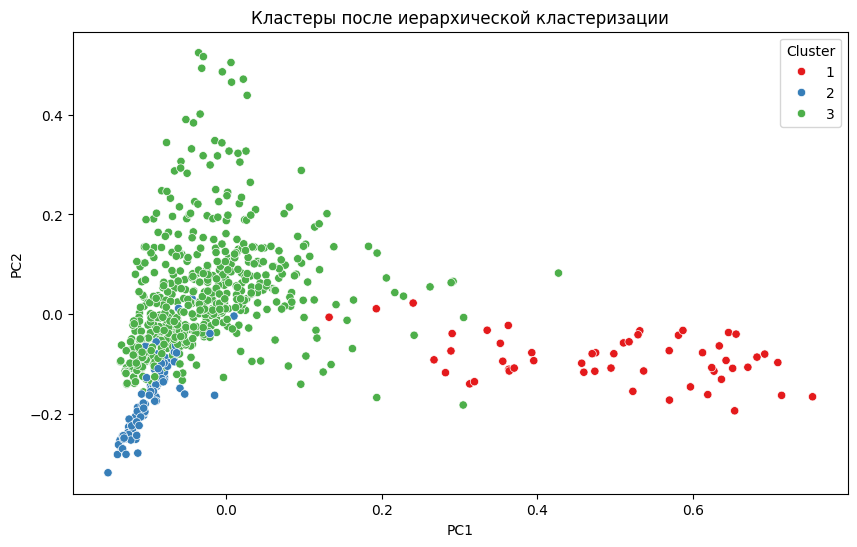

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clusters["PC1"], y=df_clusters["PC2"], hue=df_clusters["Cluster"], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеры после иерархической кластеризации")
plt.show()

Кластер 1 имеет наиболее выраженное смещение по PC1 (0.49).

Кластер 2 немного ниже по PC1 и PC2, но незначительно.

Кластер 3 — наиболее сбалансированный по первым компонентам.

C:\Users\mmd28\AppData\Local\Temp\ipykernel_2240\289758284.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_clusters["Cluster"].value_counts().index, y=df_clusters["Cluster"].value_counts().values, palette="Set2")


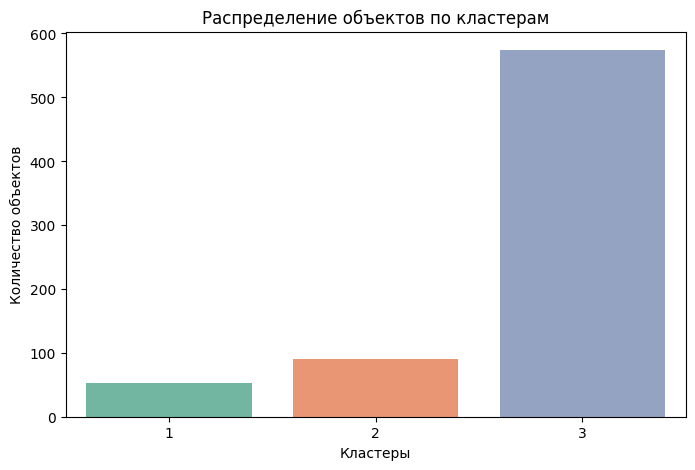

In [68]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df_clusters["Cluster"].value_counts().index, y=df_clusters["Cluster"].value_counts().values, palette="Set2")
plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.show()

In [69]:
from mpl_toolkits.mplot3d import Axes3D

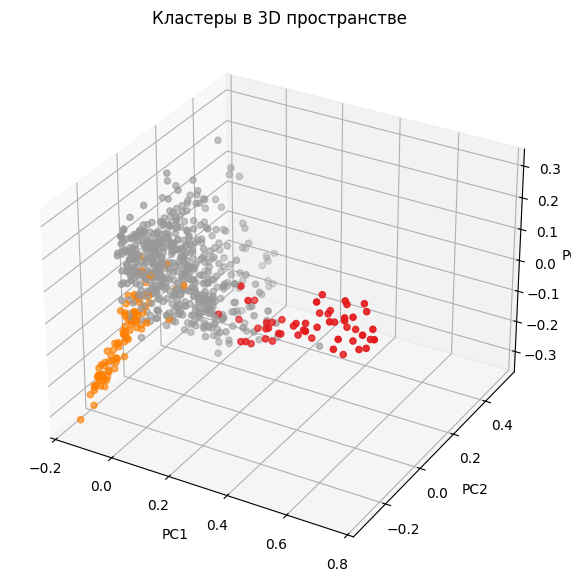

In [70]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_clusters["PC1"], df_clusters["PC2"], df_clusters["PC3"], c=df_clusters["Cluster"], cmap="Set1")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Кластеры в 3D пространстве")
plt.show()

# Кластеризация DBSCAN с подбора гиперпараметров через через кросс-валидацию

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer, silhouette_score, davies_bouldin_score

In [72]:
# Определяем диапазоны гиперпараметров для DBSCAN
param_grid = {
    'eps': np.linspace(0.1, 2, 20),  # Диапазон для eps
    'min_samples': [3, 5, 10, 20]    # Диапазоны для min_samples
}

In [73]:
# Кластеризация DBSCAN
dbscan = DBSCAN()

In [74]:
# Определим оценку для кросс-валидации, используя silhouette_score
scorer = make_scorer(silhouette_score, metric='euclidean')

In [ ]:
# Создадим GridSearchCV для поиска оптимальных гиперпараметров
grid_search = GridSearchCV(dbscan, param_grid, cv=3, scoring=scorer, n_jobs=-1)
grid_search.fit(df_clusters[["PC1", "PC2", "PC3"]])  # Используем только первые три компоненты для кластера

In [76]:
# Печатаем лучшие параметры
print(f"Лучшие гиперпараметры: {grid_search.best_params_}")
print(f"Лучший silhouette score: {grid_search.best_score_}")

Лучшие гиперпараметры: {'eps': 0.1, 'min_samples': 3}
Лучший silhouette score: nan


Ошибка с silhouette score равным nan может происходить, если кластеризация не создала никаких кластеров, или один из кластеров состоит только из одного объекта. DBSCAN имеет тенденцию оставлять точки, которые не могут быть отнесены к никакому кластеру, как выбросы (обозначенные как -1). Это может привести к ситуации, когда некоторые кластеры содержат недостаточное количество объектов для вычисления silhouette score.

Проверим количества кластеров

In [115]:
# Подбираем параметры с помощью DBSCAN
dbscan = DBSCAN(eps=0.0789, min_samples=3)
clusters = dbscan.fit_predict(df_clusters[["PC1", "PC2", "PC3"]])

In [89]:
# Подсчитываем количество кластеров (исключая выбросы, если есть)
unique_clusters = np.unique(clusters)
print(f"Количество уникальных кластеров (без учета выбросов): {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")

Количество уникальных кластеров (без учета выбросов): 1


In [90]:
# Проверяем, сколько объектов находятся в выбросах
outliers = np.sum(clusters == -1)
print(f"Количество выбросов: {outliers}")

Количество выбросов: 0


In [91]:
# Визуализируем результаты (если кластеров несколько)
if len(unique_clusters) > 1:
    plt.scatter(df_clusters["PC1"], df_clusters["PC2"], c=clusters, cmap='rainbow')
    plt.title('DBSCAN Clustering')
    plt.show()

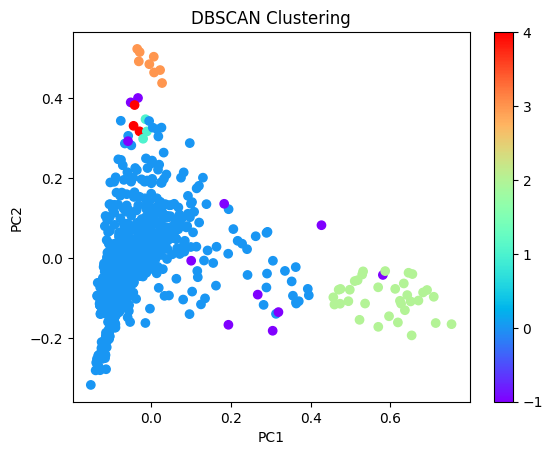

In [116]:
# Визуализируем кластеризацию на двумерном графике
plt.scatter(df_clusters["PC1"], df_clusters["PC2"], c=clusters, cmap='rainbow', label="Cluster")
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

In [108]:
# Оценка кластеризации
if len(unique_clusters) > 1:
    silhouette = silhouette_score(df_clusters[["PC1", "PC2", "PC3"]], clusters)
    db_score = davies_bouldin_score(df_clusters[["PC1", "PC2", "PC3"]], clusters)
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Score: {db_score}")
else:
    print("Недостаточно кластеров для оценки с помощью Silhouette Score.")

Недостаточно кластеров для оценки с помощью Silhouette Score.


DBSCAN не справился с задачей и не смог разделить данные на 3 кластера

# Метод K-means

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [118]:
# Инициализация модели K-means
kmeans = KMeans(n_clusters=3, random_state=42)

In [119]:
# Применяем кластеризацию
labels = kmeans.fit_predict(pca_features)

In [120]:
# Оценка качества кластеризации
silhouette_avg = silhouette_score(pca_features, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.009661510090059769


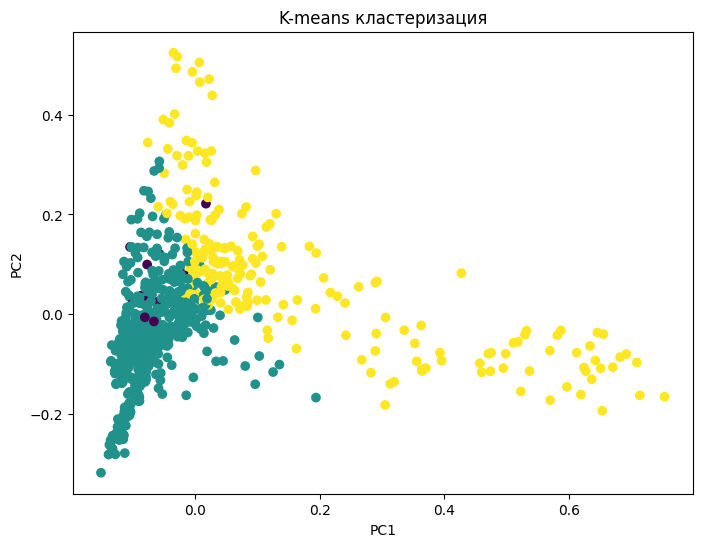

In [121]:
# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means кластеризация')
plt.show()

# Сохранение модели Hierarchical Clustering и препроцессинга

In [123]:
import joblib

In [ ]:
# Сохранение модели иерархической кластеризации (linkage matrix)
joblib.dump(linkage_matrix, 'linkage_matrix.pkl')

# Сохранение объекта PCA
joblib.dump(pca, 'pca_model.pkl')